In [13]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_validate,GridSearchCV
from sklearn.feature_selection import SelectFromModel,RFE,SelectKBest
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
from sklearn.linear_model import LogisticRegression,Lasso,LinearRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
pd.set_option('display.max_columns',None)
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [14]:
train_df=pd.read_csv('/Users/quangnguyen/Documents/Data set/Meal_Prediction_final_project_train/train.csv')
test_df=pd.read_csv('/Users/quangnguyen/Documents/Data set/Meal_Prediction_final_project_test.csv')
meal_info=pd.read_csv('/Users/quangnguyen/Documents/Data set/Meal_Prediction_final_project_train/meal_info.csv')
center=pd.read_csv('/Users/quangnguyen/Documents/Data set/Meal_Prediction_final_project_train/fulfilment_center_info.csv')


In [16]:
# merge all dataset together
train_set=pd.merge(train_df,center,on='center_id')
train_data=pd.merge(train_set,meal_info,on='meal_id')
test_set=pd.merge(test_df,center,on='center_id')
test_data=pd.merge(test_set,meal_info,on='meal_id')

In [17]:
# check for na values
train=train_data.copy()
for c in list(train.columns) :
    print(train[c].isnull().sum())

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [5]:
# descriptive stats
train.describe()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,op_area
count,4.565480e+05,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.00000,456548.000000,456548.000000,456548.000000,456548.000000
mean,1.250096e+06,74.768771,82.105796,2024.337458,332.238933,354.156627,0.081152,0.10920,261.872760,601.553399,56.614566,4.083590
std,1.443548e+05,41.524956,45.975046,547.420920,152.939723,160.715914,0.273069,0.31189,395.922798,66.195914,17.641306,1.091686
min,1.000000e+06,1.000000,10.000000,1062.000000,2.970000,55.350000,0.000000,0.00000,13.000000,456.000000,23.000000,0.900000
25%,1.124999e+06,39.000000,43.000000,1558.000000,228.950000,243.500000,0.000000,0.00000,54.000000,553.000000,34.000000,3.600000
50%,1.250184e+06,76.000000,76.000000,1993.000000,296.820000,310.460000,0.000000,0.00000,136.000000,596.000000,56.000000,4.000000
75%,1.375140e+06,111.000000,110.000000,2539.000000,445.230000,458.870000,0.000000,0.00000,324.000000,651.000000,77.000000,4.500000
max,1.499999e+06,145.000000,186.000000,2956.000000,866.270000,866.270000,1.000000,1.00000,24299.000000,713.000000,93.000000,7.000000


+ Base price usually shows higher price than the checkout_price.This is due to the fact that there might be some discounts or promotions
+ The difference between the mean and median value of num_orders is quite large,thus there might be some outliers

In [18]:
# remove outlier for train set
# choose int value only
def remove_outlier(df_in, col):
      q1 = np.percentile(df_in[col],25)
      q3 = np.percentile(df_in[col],75)
      iqr = q3-q1 #Interquartile range
      fence_low  = q1-1.5*iqr
      fence_high = q3+1.5*iqr
      df_out = df_in.loc[(df_in[col] >= fence_low) & (df_in[col] <= fence_high)]
      print(fence_high,fence_low)
      print(df_out[df_out[col]>1000])
      return df_out
training=remove_outlier(train,'num_orders')
print('Before removing outlier :',train.shape)
print('After removing outlier :',training.shape)

729.0 -351.0
Empty DataFrame
Columns: [id, week, center_id, meal_id, checkout_price, base_price, emailer_for_promotion, homepage_featured, num_orders, city_code, region_code, center_type, op_area, category, cuisine]
Index: []
Before removing outlier : (456548, 15)
After removing outlier : (423611, 15)


In [19]:
training['discount_percent']=(training['base_price']-training['checkout_price'])*100/training['base_price']
training['discount']=training['base_price']-training['checkout_price']
training['compare_week_price'] = training['checkout_price'] - training['checkout_price'].shift(1)
training['compare_week_price(y/n)'] = [1 if x > 0 else 0 for x in training['compare_week_price'].values]
training['discount(y/n)']=[1 if x >0 else 0 for x in training['discount'].values ]
training['Quarter']=(training['week']/13).astype('int64')
training['Quarter']=training['Quarter'].map({0:'Q1',
                         1:'Q2',
                         2:'Q3',
                         3:'Q4',
                         4:'Q1',
                         5:'Q2',
                         6:'Q3',
                         7:'Q4',
                         8:'Q1',
                         9:'Q2',
                         10:'Q3',
                         11:'Q4'})

<ipython-input-19-1b5c611ac661>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training['discount_percent']=(training['base_price']-training['checkout_price'])*100/training['base_price']
<ipython-input-19-1b5c611ac661>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training['discount']=training['base_price']-training['checkout_price']
<ipython-input-19-1b5c611ac661>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [6]:
non_feature=training[training['homepage_featured']==0]
feature=training[training['homepage_featured']==1]
print('Difference between featuring :',feature['num_orders'].mean() - non_feature['num_orders'].mean())
print('We can conclude that if the meals are featured at homepage there will be more orders than nothing at homepage')

Difference between featuring : 95.9238932740449
We can conclude that if the meals are featured at homepage there will be more orders than nothing at homepage


In [125]:
op_less2=training[training['op_area']< 2]
op_3=training[training['op_area']>= 3]
op_2=training.loc[(training['op_area']<3) & (training['op_area']>=2)]

In [126]:
print('operation area < 2: ',op_less2['num_orders'].mean())
print('operation area < 3: ',op_2['num_orders'].mean())
print('operation area >=3: ',op_3['num_orders'].mean())
print('As we can see, the number of avg order increases as the operation area increases,thus we could imply that wider operation area means more orders')

operation area < 2:  108.94286484301307
operation area < 3:  153.50460921119225
operation area >=3:  188.10929264602373
As we can see, the number of avg order increases as the operation area increases,thus we could imply that wider operation area means more orders


In [9]:
promotion=training[training['emailer_for_promotion']==1]
non_promotion=training[training['emailer_for_promotion']==0]
print('without promotion,average num_orders = ',non_promotion['num_orders'].mean())
print('with promotion,average num_orders = ',promotion['num_orders'].mean())
print('with the stats that we have already computed,it is apparent that promotion will encourage customers to buy the meals')

without promotion,average num_orders =  175.7897223997232
with promotion,average num_orders =  273.93082147243695
with the stats that we have already computed,it is apparent that promotion will encourage customers to buy the meals


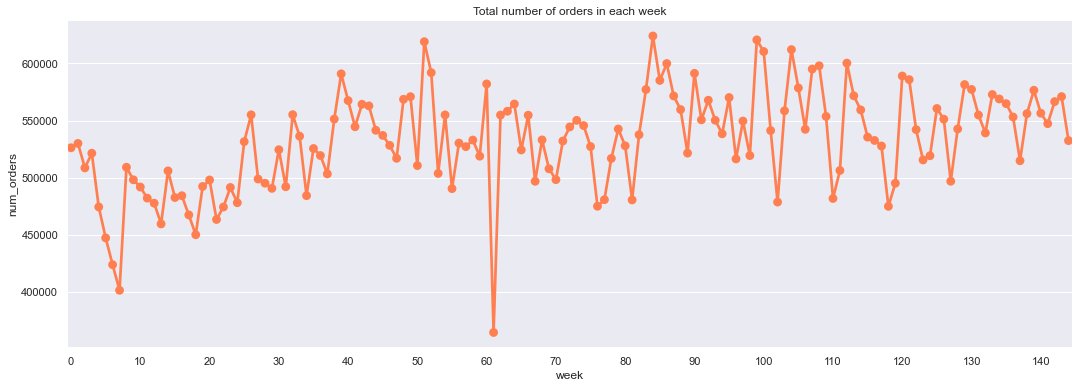

In [8]:
# number of orders in each week
week_grp=training.groupby('week')['num_orders'].sum()
week_grp=week_grp.reset_index()
sns.set(rc={'figure.figsize':(18,6)})
sns.pointplot(data=week_grp,x='week',y='num_orders',color='coral')
plt.title('Total number of orders in each week')
plt.xticks(range(0, 150, 10), list(np.arange(0,150,10)))
sns.despine(bottom = True, left = True);

In [10]:
#groupby center type 
center_grp=training.groupby('center_type').agg(Total_order=('num_orders','sum'),
                                               Average_order=('num_orders','mean'),
                                               Total_promotion=('emailer_for_promotion','sum'),
                                               Total_homepage_featured=('homepage_featured','sum'))
print(center_grp)


             Total_order  Average_order  Total_promotion  \
center_type                                                
TYPE_A          44666567     183.042447            15603   
TYPE_B          17255591     205.257542             5366   
TYPE_C          15261044     159.768049             6713   

             Total_homepage_featured  
center_type                           
TYPE_A                         22590  
TYPE_B                          7527  
TYPE_C                          7095  


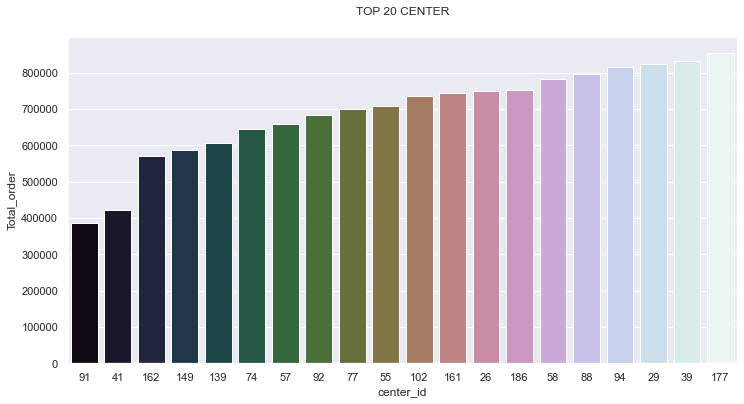

In [121]:
sub_center=training.groupby('center_id').agg(Total_order=('num_orders','sum')).sort_values('Total_order')
sub_center=sub_center.reset_index().head(20)
order_id=sub_center['center_id']
sns.set(rc={'figure.figsize':(12,6)})
sns.barplot(x='center_id',y='Total_order',data=sub_center,palette='cubehelix',order=order_id)
plt.title('TOP 20 CENTER',y=1.05)
plt.show()

In [55]:
center_a=training[training['center_type']=='TYPE_A']
center_b=training[training['center_type']=='TYPE_B']
center_c=training[training['center_type']=='TYPE_C']

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


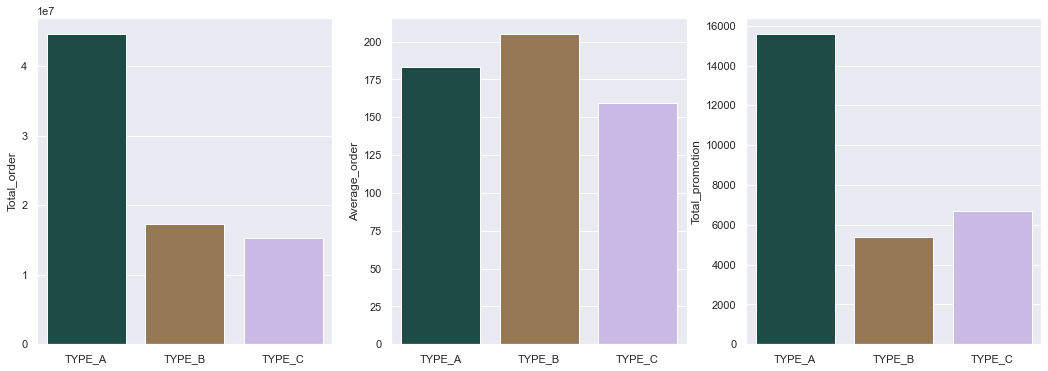

In [54]:
center_type=list(center_grp.index)
col_name=list(center_grp.columns)
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(18,6)})
f, axes = plt.subplots(1, 3)
for i,col in enumerate(col_name[:3]):
    sns.barplot(center_type,center_grp[col],ax=axes[i],palette='cubehelix')
    

In [53]:
print('Total bill of center A :',center_a.shape[0])
print('Total bill of center B :',center_b.shape[0])
print('Total bill of center C :',center_c.shape[0])
print('__________________________________')
print('\nTotal member of center_a :',len(center_a['center_id'].unique()))
print('Total member of center_b :',len(center_b['center_id'].unique()))
print('Total member of center_c :',len(center_c['center_id'].unique()))
print('__________________________________')
print('\nTotal promotion of center A :',center_a[center_a['emailer_for_promotion']==1].shape[0])
print('Total promotion of center B :',center_b[center_b['emailer_for_promotion']==1].shape[0])
print('Total promotion of center C :',center_c[center_c['emailer_for_promotion']==1].shape[0])
print('\npromo ratio of a :',len(center_a['center_id'].unique())*100/center_a[center_a['emailer_for_promotion']==1].shape[0])
print('promo ratio of b :',len(center_b['center_id'].unique())*100/center_b[center_b['emailer_for_promotion']==1].shape[0])
print('promo ratio of c :',len(center_c['center_id'].unique())*100/center_c[center_c['emailer_for_promotion']==1].shape[0])
print('__________________________________')
print('\nRatio of homepage_featured in center B :',7527*100/1725591)
print('Ratio of homepage_featured in center A :',22590*100/44666567)

Total bill of center A : 244023
Total bill of center B : 84068
Total bill of center C : 95520
__________________________________

Total member of center_a : 43
Total member of center_b : 15
Total member of center_c : 19
__________________________________

Total promotion of center A : 15603
Total promotion of center B : 5366
Total promotion of center C : 6713

promo ratio of a : 0.27558802794334425
promo ratio of b : 0.2795378307864331
promo ratio of c : 0.28303292119767615
__________________________________

Ratio of homepage_featured in center B : 0.4361983807286895
Ratio of homepage_featured in center A : 0.05057473971527742


+ Center type A got the highest number of total order but center type B achieved higher num_orders in each order because they featured more in their page based on ratio 
+ Center A achieved the largest number of bills at 244023 and Center C got higher number of bills at 95520 while Center B just had only 84068.This is due to the fact that center A has more centers than B and C
+ But why the total_order of C is less than B ?
+ Due to the stats from Total_homepage_featured,we can denote that homepage_featured stimulates customers to order more in each bill.As a result,center B got less bills than C but they attracted customers more to buy more from them in each bill by providing more homepage_featured so that the total_order of B is bigger than that of C



In [123]:
#grpby region code
region=training.groupby('region_code').agg(Total_order=('num_orders','sum'),
                                           Average_order=('num_orders','mean')).sort_values(by='Total_order')
region

,Total_order,Average_order
region_code,,
35,646347,123.726455
93,891594,163.355442
71,1020884,185.987247
23,1053848,176.464836
85,5244949,190.836450
77,16023141,175.995310
34,19125292,169.740064
56,33177147,194.853653


+ Region 56 seems to consume the highest amount of food in all 8 regions with highest total_order and average_order at 33177147 and 194.853653

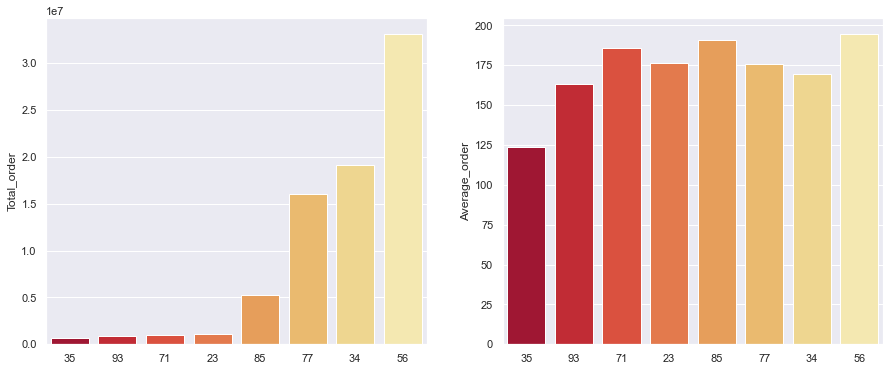

In [124]:

sns.set(rc={'figure.figsize':(15,6)})
fig,axe=plt.subplots(1,2)
for i,col in enumerate(list(region.columns)) :
    sns.barplot(y=region[col],x=list(region.index),ax=axe[i],palette='YlOrRd_r',order=list(region.index))


In [86]:
category=training.groupby('category').agg(Total_order=('num_orders','sum'),
                                          Average_order=('num_orders','mean'),
                                          Total_discount=('discount(y/n)','sum')).sort_values(by='Total_order')
category

,Total_order,Average_order,Total_discount
category,,,
Biryani,631848,30.651402,8818
Fish,869554,85.384328,4142
Soup,1039646,82.023353,5910
Pasta,1636164,59.084356,16001
Desert,1936334,66.111305,15150
Seafood,2489107,93.315851,13984
Extras,3180301,251.168931,8913
Other Snacks,4393415,151.455288,15965
Starters,4484743,150.691946,11666


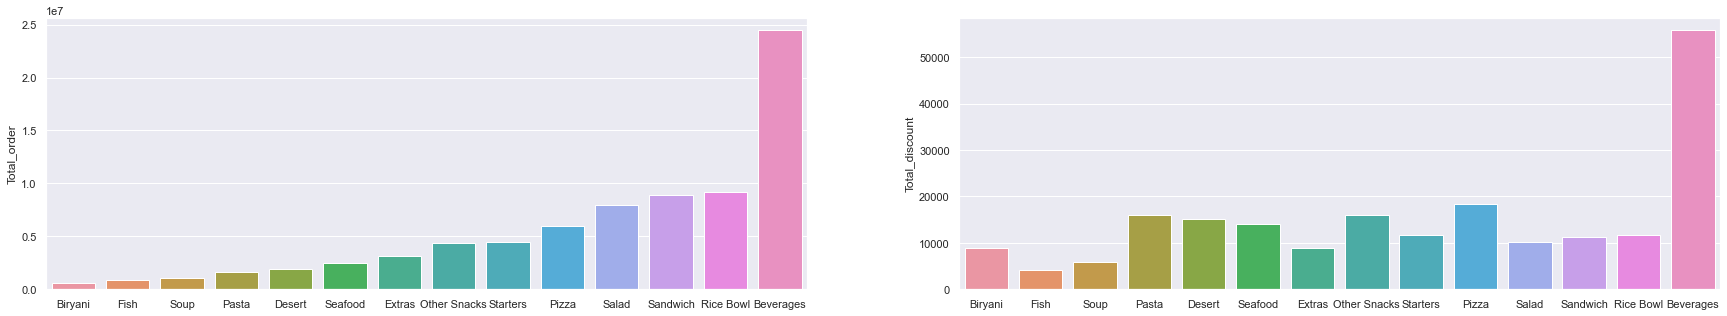

In [87]:
sns.set(rc={'figure.figsize':(30,5)})
fig,axe=plt.subplots(1,2)
for i,col in enumerate(['Total_order','Total_discount']) :
    sns.barplot(y=category[col],x=list(category.index),ax=axe[i])

+ Beverages were predominently the most favorite category of meal for customers but Rice Bowl seemed to get higher orders in each bill
+ Simultaneously,Beverages accounted for the highest number of discount

In [248]:
cuisine=training.groupby('cuisine').agg(Total_order=('num_orders','sum'),
                                           Average_order=('num_orders','mean')).sort_values(by='Total_order')
cuisine['percentage']=cuisine['Total_order']*100/cuisine['Total_order'].sum()
cuisine

,Total_order,Average_order,percentage
cuisine,,,
Indian,14023316,134.313944,18.168870
Continental,14847284,147.370509,19.236419
Thai,20964562,193.293030,27.162079
Italian,27348040,248.627586,35.432632


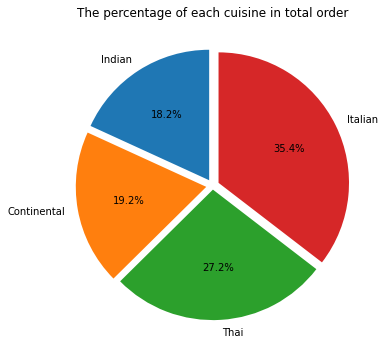

In [251]:
plt.pie(x=cuisine['percentage'].values.tolist(),autopct="%.1f%%", 
                                                shadow=False,
                                                startangle=90,
                                                explode=(0.05, 0.05, 0.03,0.05),
                                                labels=list(cuisine.index), 
                                                pctdistance=0.6)
plt.title('The percentage of each cuisine in total order')
plt.rcParams['figure.figsize']=(8,6)                                                
plt.show()

Italian food was the most popular among other cuisines with the highest Total_order and average_order in each bill

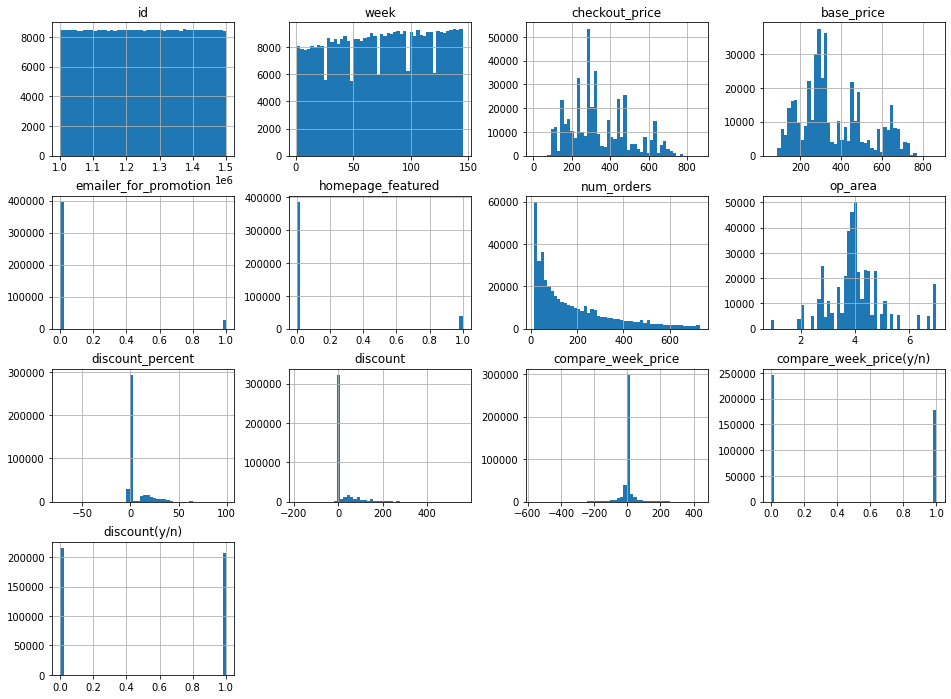

In [115]:

plt.rcParams["figure.figsize"]=(16,12)
training.hist(bins=50)
plt.show()

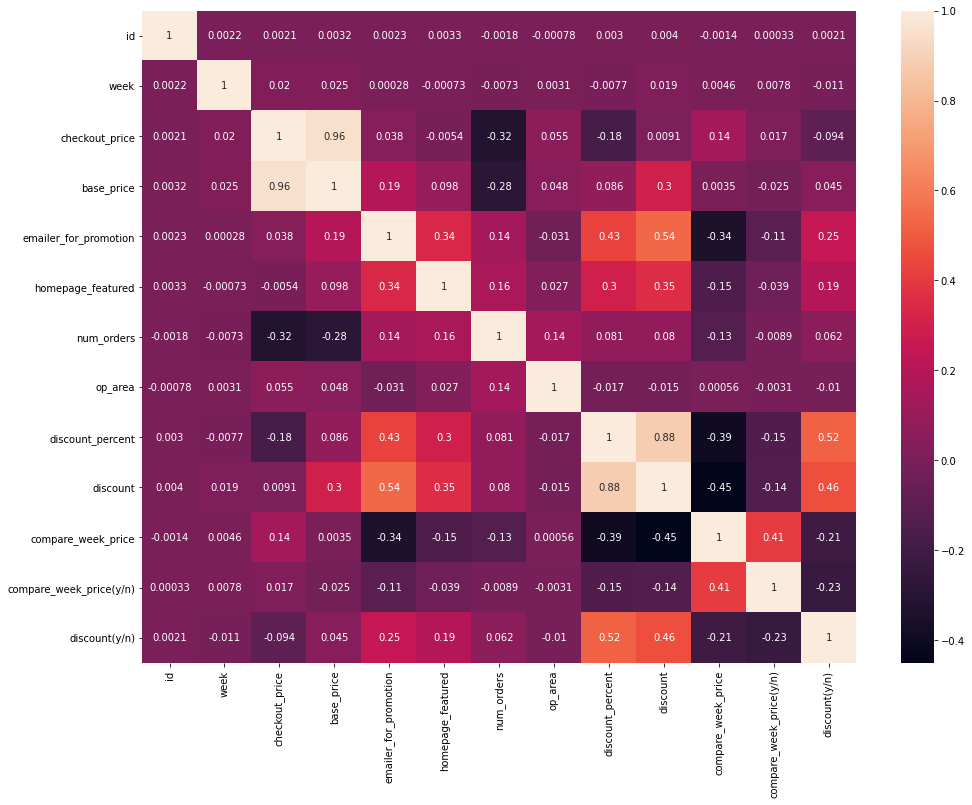

In [116]:
sns.heatmap(training.corr(),annot=True)
plt.show()

In [21]:
training['center_id']=(training['center_id']).astype('O')
training['meal_id']=(training['meal_id']).astype('O')
training['city_code']=(training['city_code']).astype('O')
training['region_code']=(training['region_code']).astype('O')


<ipython-input-21-af1f8aff091c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training['center_id']=(training['center_id']).astype('O')
<ipython-input-21-af1f8aff091c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training['meal_id']=(training['meal_id']).astype('O')
<ipython-input-21-af1f8aff091c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [22]:
# evaluate model without tuning
training_tune=training.copy()
cat_feature=[f for f in training.columns.tolist() if training[f].dtype == 'O']
for col in cat_feature :
    label=LabelEncoder()
    training[col]=label.fit_transform(training[col])
training['compare_week_price']=training['compare_week_price'].replace(np.nan,training['compare_week_price'].median())
training_X=training.drop(['num_orders'],axis=1)
training_Y=training[['num_orders']]
xtrain,val_x,ytrain,val_y=train_test_split(training_X,training_Y,test_size=0.3)
light=LGBMRegressor()
linear=LinearRegression()
xg=XGBRegressor()
xg.fit(training_X,training_Y)
linear.fit(training_X,training_Y)
light.fit(training_X,training_Y)
print('XGB :',r2_score(val_y,xg.predict(val_x)))
print('LGBM :',r2_score(val_y,light.predict(val_x)))
print('Linear Regression :',r2_score(val_y,linear.predict(val_x)))
print('only choose LGBM an not Linear for finding tune')

<ipython-input-22-666c6a78ad61>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training[col]=label.fit_transform(training[col])
<ipython-input-22-666c6a78ad61>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training['compare_week_price']=training['compare_week_price'].replace(np.nan,training['compare_week_price'].median())


KeyboardInterrupt: 

In [99]:
print('XGB :',np.sqrt(mean_squared_error(val_y,xg.predict(val_x))))
print('LGBM :',np.sqrt(mean_squared_error(val_y,light.predict(val_x))))


XGB : 76.48250355712858
LGBM : 87.51911460967473


In [23]:
training_tune['center_id']=(training_tune['center_id']).astype('O')
training_tune['meal_id']=(training_tune['meal_id']).astype('O')
training_tune['city_code']=(training_tune['city_code']).astype('O')
training_tune['region_code']=(training_tune['region_code']).astype('O')

onehot_feat=pd.get_dummies(training_tune[['center_type','category','cuisine','center_id','meal_id','city_code','region_code']])
full_train=pd.concat([training_tune,onehot_feat],axis=1)
full_train                                                              

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,discount_percent,discount,compare_week_price,compare_week_price(y/n),discount(y/n),Quarter,center_type_TYPE_A,center_type_TYPE_B,center_type_TYPE_C,category_Beverages,category_Biryani,category_Desert,category_Extras,category_Fish,category_Other Snacks,category_Pasta,category_Pizza,category_Rice Bowl,category_Salad,category_Sandwich,category_Seafood,category_Soup,category_Starters,cuisine_Continental,cuisine_Indian,cuisine_Italian,cuisine_Thai,center_id_10,center_id_11,center_id_13,center_id_14,center_id_17,center_id_20,center_id_23,center_id_24,center_id_26,center_id_27,center_id_29,center_id_30,center_id_32,center_id_34,center_id_36,center_id_39,center_id_41,center_id_42,center_id_43,center_id_50,center_id_51,center_id_52,center_id_53,center_id_55,center_id_57,center_id_58,center_id_59,center_id_61,center_id_64,center_id_65,center_id_66,center_id_67,center_id_68,center_id_72,center_id_73,center_id_74,center_id_75,center_id_76,center_id_77,center_id_80,center_id_81,center_id_83,center_id_86,center_id_88,center_id_89,center_id_91,center_id_92,center_id_93,center_id_94,center_id_97,center_id_99,center_id_101,center_id_102,center_id_104,center_id_106,center_id_108,center_id_109,center_id_110,center_id_113,center_id_124,center_id_126,center_id_129,center_id_132,center_id_137,center_id_139,center_id_143,center_id_145,center_id_146,center_id_149,center_id_152,center_id_153,center_id_157,center_id_161,center_id_162,center_id_174,center_id_177,center_id_186,meal_id_1062,meal_id_1109,meal_id_1198,meal_id_1207,meal_id_1216,meal_id_1230,meal_id_1247,meal_id_1248,meal_id_1311,meal_id_1438,meal_id_1445,meal_id_1525,meal_id_1543,meal_id_1558,meal_id_1571,meal_id_1727,meal_id_1754,meal_id_1770,meal_id_1778,meal_id_1803,meal_id_1847,meal_id_1878,meal_id_1885,meal_id_1902,meal_id_1962,meal_id_1971,meal_id_1993,meal_id_2104,meal_id_2126,meal_id_2139,meal_id_2290,meal_id_2304,meal_id_2306,meal_id_2322,meal_id_2444,meal_id_2490,meal_id_2492,meal_id_2494,meal_id_2539,meal_id_2569,meal_id_2577,meal_id_2581,meal_id_2631,meal_id_2640,meal_id_2664,meal_id_2704,meal_id_2707,meal_id_2760,meal_id_2826,meal_id_2867,meal_id_2956,city_code_456,city_code_461,city_code_473,city_code_478,city_code_485,city_code_515,city_code_517,city_code_522,city_code_526,city_code_541,city_code_553,city_code_556,city_code_561,city_code_562,city_code_576,city_code_577,city_code_579,city_code_590,city_code_593,city_code_596,city_code_599,city_code_602,city_code_604,city_code_609,city_code_614,city_code_615,city_code_620,city_code_628,city_code_632,city_code_638,city_code_647,city_code_648,city_code_649,city_code_651,city_code_654,city_code_658,city_code_659,city_code_675,city_code_676,city_code_679,city_code_680,city_code_683,city_code_685,city_code_693,city_code_695,city_code_698,city_code_699,city_code_700,city_code_702,city_code_703,city_code_713,region_code_23,region_code_34,region_code_35,region_code_56,region_code_71,region_code_77,region_code_85,region_code_93
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai,10.151684,15.46,NaN,0,1,Q1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,1018704,2,55,1885,135.83,152.29,0,0,323,647,56,TYPE_C,2.0,Beverages,Thai,10.808326,16.46,-1.00,0,1,Q1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,

In [24]:

cat_feat=[f for f in full_train.columns.tolist() if full_train[f].dtype == 'O']
for col in cat_feat :
    label=LabelEncoder()
    full_train[col]=label.fit_transform(full_train[col])
full_train['compare_week_price']=full_train['compare_week_price'].replace(np.nan,full_train['compare_week_price'].median())
full_train

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,discount_percent,discount,compare_week_price,compare_week_price(y/n),discount(y/n),Quarter,center_type_TYPE_A,center_type_TYPE_B,center_type_TYPE_C,category_Beverages,category_Biryani,category_Desert,category_Extras,category_Fish,category_Other Snacks,category_Pasta,category_Pizza,category_Rice Bowl,category_Salad,category_Sandwich,category_Seafood,category_Soup,category_Starters,cuisine_Continental,cuisine_Indian,cuisine_Italian,cuisine_Thai,center_id_10,center_id_11,center_id_13,center_id_14,center_id_17,center_id_20,center_id_23,center_id_24,center_id_26,center_id_27,center_id_29,center_id_30,center_id_32,center_id_34,center_id_36,center_id_39,center_id_41,center_id_42,center_id_43,center_id_50,center_id_51,center_id_52,center_id_53,center_id_55,center_id_57,center_id_58,center_id_59,center_id_61,center_id_64,center_id_65,center_id_66,center_id_67,center_id_68,center_id_72,center_id_73,center_id_74,center_id_75,center_id_76,center_id_77,center_id_80,center_id_81,center_id_83,center_id_86,center_id_88,center_id_89,center_id_91,center_id_92,center_id_93,center_id_94,center_id_97,center_id_99,center_id_101,center_id_102,center_id_104,center_id_106,center_id_108,center_id_109,center_id_110,center_id_113,center_id_124,center_id_126,center_id_129,center_id_132,center_id_137,center_id_139,center_id_143,center_id_145,center_id_146,center_id_149,center_id_152,center_id_153,center_id_157,center_id_161,center_id_162,center_id_174,center_id_177,center_id_186,meal_id_1062,meal_id_1109,meal_id_1198,meal_id_1207,meal_id_1216,meal_id_1230,meal_id_1247,meal_id_1248,meal_id_1311,meal_id_1438,meal_id_1445,meal_id_1525,meal_id_1543,meal_id_1558,meal_id_1571,meal_id_1727,meal_id_1754,meal_id_1770,meal_id_1778,meal_id_1803,meal_id_1847,meal_id_1878,meal_id_1885,meal_id_1902,meal_id_1962,meal_id_1971,meal_id_1993,meal_id_2104,meal_id_2126,meal_id_2139,meal_id_2290,meal_id_2304,meal_id_2306,meal_id_2322,meal_id_2444,meal_id_2490,meal_id_2492,meal_id_2494,meal_id_2539,meal_id_2569,meal_id_2577,meal_id_2581,meal_id_2631,meal_id_2640,meal_id_2664,meal_id_2704,meal_id_2707,meal_id_2760,meal_id_2826,meal_id_2867,meal_id_2956,city_code_456,city_code_461,city_code_473,city_code_478,city_code_485,city_code_515,city_code_517,city_code_522,city_code_526,city_code_541,city_code_553,city_code_556,city_code_561,city_code_562,city_code_576,city_code_577,city_code_579,city_code_590,city_code_593,city_code_596,city_code_599,city_code_602,city_code_604,city_code_609,city_code_614,city_code_615,city_code_620,city_code_628,city_code_632,city_code_638,city_code_647,city_code_648,city_code_649,city_code_651,city_code_654,city_code_658,city_code_659,city_code_675,city_code_676,city_code_679,city_code_680,city_code_683,city_code_685,city_code_693,city_code_695,city_code_698,city_code_699,city_code_700,city_code_702,city_code_703,city_code_713,region_code_23,region_code_34,region_code_35,region_code_56,region_code_71,region_code_77,region_code_85,region_code_93
0,1379560,1,23,22,136.83,152.29,0,0,177,30,3,2,2.0,0,3,10.151684,15.46,0.00,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,1018704,2,23,22,135.83,152.29,0,0,323,30,3,2,2.0,0,3,10.808326,16.46,-1.00,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [26]:
training_x=full_train.drop(['num_orders'],axis=1)
training_y=np.asanyarray(full_train[['num_orders']])
training_original_x=training_x.copy()
num_feat=len(training_x.columns.tolist())

In [27]:
select=SelectKBest(k=150)
select.fit(training_x,training_y)
select_sup=select.get_support()
feats=training_x.loc[:,select_sup].columns.tolist()
feats

/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


['center_id',
 'meal_id',
 'checkout_price',
 'base_price',
 'emailer_for_promotion',
 'homepage_featured',
 'city_code',
 'center_type',
 'op_area',
 'category',
 'cuisine',
 'discount_percent',
 'discount',
 'compare_week_price',
 'discount(y/n)',
 'center_type_TYPE_B',
 'center_type_TYPE_C',
 'category_Beverages',
 'category_Biryani',
 'category_Desert',
 'category_Extras',
 'category_Fish',
 'category_Other Snacks',
 'category_Pasta',
 'category_Pizza',
 'category_Rice Bowl',
 'category_Salad',
 'category_Sandwich',
 'category_Seafood',
 'category_Soup',
 'category_Starters',
 'cuisine_Continental',
 'cuisine_Indian',
 'cuisine_Italian',
 'cuisine_Thai',
 'center_id_10',
 'center_id_11',
 'center_id_13',
 'center_id_24',
 'center_id_26',
 'center_id_41',
 'center_id_43',
 'center_id_52',
 'center_id_55',
 'center_id_57',
 'center_id_65',
 'center_id_66',
 'center_id_67',
 'center_id_72',
 'center_id_74',
 'center_id_75',
 'center_id_77',
 'center_id_80',
 'center_id_86',
 'center_i

<AxesSubplot:>

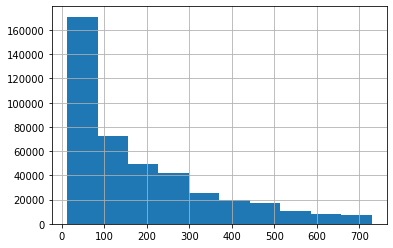

In [76]:
training['num_orders'].hist() # --> skewed left use log transform

In [28]:
scale_select=StandardScaler()
train_y=np.log(training_y)
selected_x=scale_select.fit_transform(training_x[feats])
select_xtrain,val_select_x,select_ytrain,val_select_y=train_test_split(selected_x,train_y,test_size=0.3)

In [34]:

light_model=LGBMRegressor(boosting_type='gbdt',
                         objective='regression',
                         max_depth=11,
                         learning_rate = 0.8,
                         num_leaves =100,
                         feature_fraction = 0.7,
                         min_data_in_leaf= 96,
                         bagging_fraction= 0.2,
                         metric= 'rmse',
                         random_state=100,
                         seed=4)
light_model.fit(np.asanyarray(select_xtrain),select_ytrain.ravel())
print(r2_score(select_ytrain,light_model.predict(select_xtrain)))
print(r2_score(val_select_y,light_model.predict(val_select_x)))
print(np.sqrt(mean_squared_error(val_select_y,light_model.predict(val_select_x))))

[LightGBM] [Warning] min_data_in_leaf is set=96, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=96
[LightGBM] [Warning] seed is set=4, random_state=100 will be ignored. Current value: seed=4
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
0.8113540458723287
0.7807096172705899
0.5099220464351


In [38]:
xg_model=XGBRegressor(max_depth = 10,
                      learning_rate=0.5, 
                      objective= 'reg:linear',  
                      eval_metric= 'rmse',
                      eta=0.8,
                      gamma=0.9,
                      max_delta_step=2,
                      seed= 4)
xg_model.fit(np.asanyarray(select_xtrain),select_ytrain.ravel())
print(r2_score(select_ytrain,xg_model.predict(select_xtrain)))
print(r2_score(val_select_y,xg_model.predict(val_select_x)))
print(np.sqrt(mean_squared_error(val_select_y,xg_model.predict(val_select_x))))

[20:05:43] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
0.8352266807366558
0.7844782151893227
0.5055214449982374


In [81]:
test_data.describe()

,id,week,checkout_price,base_price,emailer_for_promotion,homepage_featured,op_area,discount_percent,discount,compare_week_price,compare_week_price(y/n),discount(y/n)
count,3.257300e+04,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000,32572.000000,32573.000000,32573.000000
mean,1.248476e+06,150.477819,341.854440,356.493615,0.066435,0.081356,4.087726,4.359922,14.639175,0.014504,0.422221,0.458048
std,1.441580e+05,2.864072,153.893886,155.150101,0.249045,0.273385,1.098835,10.450501,39.374791,40.550603,0.493921,0.498245
min,1.000085e+06,146.000000,67.900000,89.240000,0.000000,0.000000,0.900000,-26.753083,-76.570000,-821.590000,0.000000,0.000000
25%,1.123969e+06,148.000000,214.430000,243.500000,0.000000,0.000000,3.600000,-0.177746,-1.000000,-2.000000,0.000000,0.000000
50%,1.247296e+06,150.000000,320.130000,321.130000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.372971e+06,153.000000,446.230000,455.930000,0.000000,0.000000,4.500000,0.622801,2.000000,2.000000,1.000000,1.000000
max,1.499996e+06,155.000000,1113.620000,1112.620000,1.000000,1.000000,7.000000,73.752944,820.590000,872.090000,1.000000,1.000000


In [50]:
test_data['discount_percent']=(test_data['base_price']-test_data['checkout_price'])*100/test_data['base_price']
test_data['discount']=test_data['base_price']-test_data['checkout_price']
test_data['compare_week_price'] = test_data['checkout_price'] - test_data['checkout_price'].shift(1)
test_data['compare_week_price(y/n)'] = [1 if x > 0 else 0 for x in test_data['compare_week_price'].values]
test_data['discount(y/n)']=[1 if x >0 else 0 for x in test_data['discount'].values ]
test_data['center_id']=(test_data['center_id']).astype('O')
test_data['meal_id']=(test_data['meal_id']).astype('O')
test_data['city_code']=(test_data['city_code']).astype('O')
test_data['region_code']=(test_data['region_code']).astype('O')
test_data['Quarter']=(test_data['week']/13).astype('int64')
test_data['Quarter']=test_data['Quarter'].map({0:'Q1',
                         1:'Q2',
                         2:'Q3',
                         3:'Q4',
                         4:'Q1',
                         5:'Q2',
                         6:'Q3',
                         7:'Q4',
                         8:'Q1',
                         9:'Q2',
                         10:'Q3',
                         11:'Q4'})
test_data

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,region_code,center_type,op_area,category,cuisine,discount_percent,discount,compare_week_price,compare_week_price(y/n),discount(y/n),Quarter
0,1028232,146,55,1885,158.11,159.11,0,0,647,56,TYPE_C,2.0,Beverages,Thai,0.628496,1.0,NaN,0,1,Q4
1,1262649,147,55,1885,159.11,159.11,0,0,647,56,TYPE_C,2.0,Beverages,Thai,0.000000,0.0,1.00,1,0,Q4
2,1453211,149,55,1885,157.14,158.14,0,0,647,56,TYPE_C,2.0,Beverages,Thai,0.632351,1.0,-1.97,0,1,Q4
3,1262599,150,55,1885,159.14,157.14,0,0,647,56,TYPE_C,2.0,Beverages,Thai,-1.272750,-2.0,2.00,1,0,Q4
4,1495848,151,55,1885,160.11,159.11,0,0,647,56,TYPE_C,2.0,Beverages,Thai,-0.628496,-1.0,0.97,1,0,Q4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32568,1412025,146,61,2104,583.03,581.03,0,0,473,77,TYPE_A,4.5,Fish,Continental,-0.344216,-2.0,-97.00,0,0,Q4
32569,1287019,147,61,2104,582.03,582.03,0,1,473,77,TYPE_A,4.5,Fish,Continental,0.000000,0.0,-1.00,0,0,Q4
32570,1396176,149,61,2104,629.53,629.53,0,0,473,77,TYPE_A,4.5,Fish,Continental,0.000000,0.0,47.50,1,0,Q4
32571,1331977,150,61,2104,629.53,629.53,0,0,473,77,TYPE_A,4.5,Fish,Continental,0.000000,0.0,0.00,0,0,Q4


In [51]:
onehot_test=pd.get_dummies(test_data[['center_type','category','cuisine','center_id','meal_id','city_code','region_code']])
full_test=pd.concat([test_data ,onehot_test],axis=1)
full_test['compare_week_price']=full_test['compare_week_price'].replace(np.nan,full_test['compare_week_price'].mean())
full_test

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,region_code,center_type,op_area,category,cuisine,discount_percent,discount,compare_week_price,compare_week_price(y/n),discount(y/n),Quarter,center_type_TYPE_A,center_type_TYPE_B,center_type_TYPE_C,category_Beverages,category_Biryani,category_Desert,category_Extras,category_Fish,category_Other Snacks,category_Pasta,category_Pizza,category_Rice Bowl,category_Salad,category_Sandwich,category_Seafood,category_Soup,category_Starters,cuisine_Continental,cuisine_Indian,cuisine_Italian,cuisine_Thai,center_id_10,center_id_11,center_id_13,center_id_14,center_id_17,center_id_20,center_id_23,center_id_24,center_id_26,center_id_27,center_id_29,center_id_30,center_id_32,center_id_34,center_id_36,center_id_39,center_id_41,center_id_42,center_id_43,center_id_50,center_id_51,center_id_52,center_id_53,center_id_55,center_id_57,center_id_58,center_id_59,center_id_61,center_id_64,center_id_65,center_id_66,center_id_67,center_id_68,center_id_72,center_id_73,center_id_74,center_id_75,center_id_76,center_id_77,center_id_80,center_id_81,center_id_83,center_id_86,center_id_88,center_id_89,center_id_91,center_id_92,center_id_93,center_id_94,center_id_97,center_id_99,center_id_101,center_id_102,center_id_104,center_id_106,center_id_108,center_id_109,center_id_110,center_id_113,center_id_124,center_id_126,center_id_129,center_id_132,center_id_137,center_id_139,center_id_143,center_id_145,center_id_146,center_id_149,center_id_152,center_id_153,center_id_157,center_id_161,center_id_162,center_id_174,center_id_177,center_id_186,meal_id_1062,meal_id_1109,meal_id_1198,meal_id_1207,meal_id_1216,meal_id_1230,meal_id_1247,meal_id_1248,meal_id_1311,meal_id_1438,meal_id_1445,meal_id_1525,meal_id_1543,meal_id_1558,meal_id_1571,meal_id_1727,meal_id_1754,meal_id_1770,meal_id_1778,meal_id_1803,meal_id_1847,meal_id_1878,meal_id_1885,meal_id_1902,meal_id_1962,meal_id_1971,meal_id_1993,meal_id_2104,meal_id_2126,meal_id_2139,meal_id_2290,meal_id_2304,meal_id_2306,meal_id_2322,meal_id_2444,meal_id_2490,meal_id_2492,meal_id_2494,meal_id_2539,meal_id_2569,meal_id_2577,meal_id_2581,meal_id_2631,meal_id_2640,meal_id_2664,meal_id_2704,meal_id_2707,meal_id_2760,meal_id_2826,meal_id_2867,meal_id_2956,city_code_456,city_code_461,city_code_473,city_code_478,city_code_485,city_code_515,city_code_517,city_code_522,city_code_526,city_code_541,city_code_553,city_code_556,city_code_561,city_code_562,city_code_576,city_code_577,city_code_579,city_code_590,city_code_593,city_code_596,city_code_599,city_code_602,city_code_604,city_code_609,city_code_614,city_code_615,city_code_620,city_code_628,city_code_632,city_code_638,city_code_647,city_code_648,city_code_649,city_code_651,city_code_654,city_code_658,city_code_659,city_code_675,city_code_676,city_code_679,city_code_680,city_code_683,city_code_685,city_code_693,city_code_695,city_code_698,city_code_699,city_code_700,city_code_702,city_code_703,city_code_713,region_code_23,region_code_34,region_code_35,region_code_56,region_code_71,region_code_77,region_code_85,region_code_93
0,1028232,146,55,1885,158.11,159.11,0,0,647,56,TYPE_C,2.0,Beverages,Thai,0.628496,1.0,0.014504,0,1,Q4,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,1262649,147,55,1885,159.11,159.11,0,0,647,56,TYPE_C,2.0,Beverages,Thai,0.000000,0.0,1.000000,1,0,Q4,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0

In [52]:
cat_test=[f for f in full_test.columns.tolist() if full_test[f].dtype == 'O']
for col in cat_test :
    label=LabelEncoder()
    full_test[col]=label.fit_transform(full_test[col])
full_test

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,region_code,center_type,op_area,category,cuisine,discount_percent,discount,compare_week_price,compare_week_price(y/n),discount(y/n),Quarter,center_type_TYPE_A,center_type_TYPE_B,center_type_TYPE_C,category_Beverages,category_Biryani,category_Desert,category_Extras,category_Fish,category_Other Snacks,category_Pasta,category_Pizza,category_Rice Bowl,category_Salad,category_Sandwich,category_Seafood,category_Soup,category_Starters,cuisine_Continental,cuisine_Indian,cuisine_Italian,cuisine_Thai,center_id_10,center_id_11,center_id_13,center_id_14,center_id_17,center_id_20,center_id_23,center_id_24,center_id_26,center_id_27,center_id_29,center_id_30,center_id_32,center_id_34,center_id_36,center_id_39,center_id_41,center_id_42,center_id_43,center_id_50,center_id_51,center_id_52,center_id_53,center_id_55,center_id_57,center_id_58,center_id_59,center_id_61,center_id_64,center_id_65,center_id_66,center_id_67,center_id_68,center_id_72,center_id_73,center_id_74,center_id_75,center_id_76,center_id_77,center_id_80,center_id_81,center_id_83,center_id_86,center_id_88,center_id_89,center_id_91,center_id_92,center_id_93,center_id_94,center_id_97,center_id_99,center_id_101,center_id_102,center_id_104,center_id_106,center_id_108,center_id_109,center_id_110,center_id_113,center_id_124,center_id_126,center_id_129,center_id_132,center_id_137,center_id_139,center_id_143,center_id_145,center_id_146,center_id_149,center_id_152,center_id_153,center_id_157,center_id_161,center_id_162,center_id_174,center_id_177,center_id_186,meal_id_1062,meal_id_1109,meal_id_1198,meal_id_1207,meal_id_1216,meal_id_1230,meal_id_1247,meal_id_1248,meal_id_1311,meal_id_1438,meal_id_1445,meal_id_1525,meal_id_1543,meal_id_1558,meal_id_1571,meal_id_1727,meal_id_1754,meal_id_1770,meal_id_1778,meal_id_1803,meal_id_1847,meal_id_1878,meal_id_1885,meal_id_1902,meal_id_1962,meal_id_1971,meal_id_1993,meal_id_2104,meal_id_2126,meal_id_2139,meal_id_2290,meal_id_2304,meal_id_2306,meal_id_2322,meal_id_2444,meal_id_2490,meal_id_2492,meal_id_2494,meal_id_2539,meal_id_2569,meal_id_2577,meal_id_2581,meal_id_2631,meal_id_2640,meal_id_2664,meal_id_2704,meal_id_2707,meal_id_2760,meal_id_2826,meal_id_2867,meal_id_2956,city_code_456,city_code_461,city_code_473,city_code_478,city_code_485,city_code_515,city_code_517,city_code_522,city_code_526,city_code_541,city_code_553,city_code_556,city_code_561,city_code_562,city_code_576,city_code_577,city_code_579,city_code_590,city_code_593,city_code_596,city_code_599,city_code_602,city_code_604,city_code_609,city_code_614,city_code_615,city_code_620,city_code_628,city_code_632,city_code_638,city_code_647,city_code_648,city_code_649,city_code_651,city_code_654,city_code_658,city_code_659,city_code_675,city_code_676,city_code_679,city_code_680,city_code_683,city_code_685,city_code_693,city_code_695,city_code_698,city_code_699,city_code_700,city_code_702,city_code_703,city_code_713,region_code_23,region_code_34,region_code_35,region_code_56,region_code_71,region_code_77,region_code_85,region_code_93
0,1028232,146,23,22,158.11,159.11,0,0,30,3,2,2.0,0,3,0.628496,1.0,0.014504,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,1262649,147,23,22,159.11,159.11,0,0,30,3,2,2.0,0,3,0.000000,0.0,1.000000,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [54]:
test_select_x=select.transform(full_test)
test_select_x=scale_select.transform(test_select_x)

In [56]:
# lightgbm has the highest acc for test on website
y_hat_lightgbm=light_model.predict(test_select_x)
y_hat_xg=xg_model.predict(test_select_x)
result=pd.DataFrame({'id':full_test['id'],'num_orders':np.exp(y_hat_xg)})
result

,id,num_orders
0,1028232,139.112335
1,1262649,136.230927
2,1453211,123.754974
3,1262599,168.551468
4,1495848,176.250870
...,...,...
32568,1412025,33.009121
32569,1287019,47.736610
32570,1396176,22.482494
32571,1331977,29.096298


In [57]:
res=result.to_csv('/Users/quangnguyen/Library/Mobile Documents/com~apple~CloudDocs/DS-DungLai/Deep Learning/Machine Learning/meal_prediction_xg.csv',index=False)